In [99]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import HiveContext, Row
from pyspark.sql.types import IntegerType
import json
import sys
import pandas as pd


inputFile = 'mydata/health_data.csv'

conf = SparkConf().setAppName("SparkSQLAirTransit")
SparkConf().set("spark.sql.legacy.timeParserPolicy","LEGACY")

sc = SparkContext.getOrCreate(conf=conf)
hiveCtx = HiveContext(sc)
print("Loading data from " + inputFile)

Loading data from mydata/health_data.csv


In [100]:
df = hiveCtx.read.option("header",True).csv(inputFile,inferSchema =True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: integer (nullable = true)
 |-- drink: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- diabetes: integer (nullable = true)



In [101]:
print('查看据据sample,进行数据索索')
pd.DataFrame(df.take(10), columns=df.columns).transpose()

查看据据sample,进行数据索索


,0,1,2,3,4,5,6,7,8,9
age,89,87,82,76,68,81,87,75,60,90
bmi,23,29,30,20,24,11,23,22,14,29
drink,0,0,0,1,1,1,0,1,0,0
heart_disease,0,1,0,1,0,1,0,1,0,1
diabetes,1,0,1,0,1,1,1,0,1,1


相性性分析


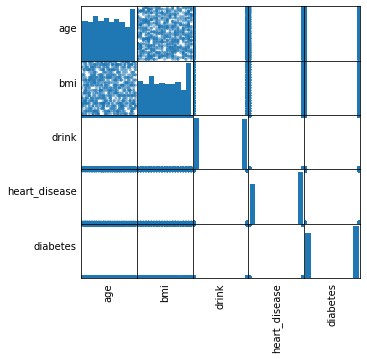

In [102]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

print('相性性分析')
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(5, 5));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [103]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['age','bmi','drink','diabetes']
stages = []
# for categoricalCol in categoricalColumns:
#     stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
#     encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
#     stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'heart_disease', outputCol = 'label')
stages += [label_stringIdx]
numericCols = categoricalColumns
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [104]:

from pyspark.ml import Pipeline
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)

In [105]:
print('数集集拆分')
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

数集集拆分
Training Dataset Count: 712
Test Dataset Count: 288


In [106]:
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import RandomForestClassifier
lr = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
# lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

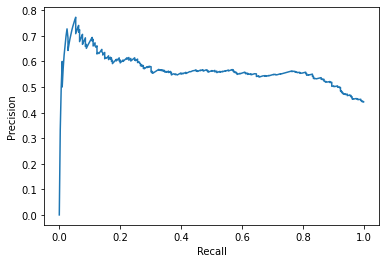

In [107]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [108]:
print('监督机器学习机森林林结果：')
predictions = lrModel.transform(test)
predictions.select('age','bmi','drink','diabetes', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

监督机器学习机森林林结果：
+---+---+-----+--------+-----+--------------------+----------+--------------------+
|age|bmi|drink|diabetes|label|       rawPrediction|prediction|         probability|
+---+---+-----+--------+-----+--------------------+----------+--------------------+
| 60| 10|    1|       1|  0.0|[8.21096366963330...|       1.0|[0.41054818348166...|
| 60| 28|    1|       0|  0.0|[6.57111308263879...|       1.0|[0.32855565413194...|
| 61| 14|    0|       1|  0.0|[5.98586065352853...|       1.0|[0.29929303267642...|
| 61| 14|    1|       1|  0.0|[7.46771828506813...|       1.0|[0.37338591425340...|
| 61| 25|    0|       1|  0.0|[7.41430836706518...|       1.0|[0.37071541835325...|
| 62| 11|    1|       0|  0.0|[9.22979067279712...|       1.0|[0.46148953363985...|
| 62| 15|    0|       1|  0.0|[6.73401678801190...|       1.0|[0.33670083940059...|
| 62| 20|    0|       1|  0.0|[7.18702204346017...|       1.0|[0.35935110217300...|
| 62| 22|    1|       1|  0.0|[8.15284251446391...|       1.0|

In [109]:
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import RandomForestClassifier
# lr = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

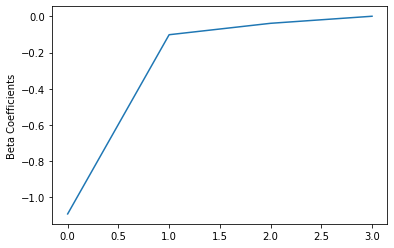

In [110]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

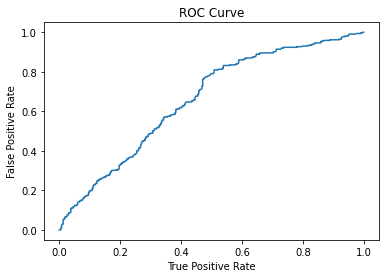

Training set areaUnderROC: 0.6586661868777741


In [111]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

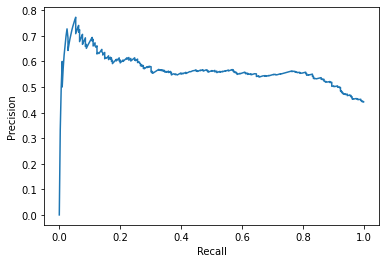

In [112]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [113]:
print('监督机器学习逻辑回归之结果：')
predictions = lrModel.transform(test)
predictions.select('age','bmi','drink','diabetes', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

监督机器学习逻辑回归之结果：
+---+---+-----+--------+-----+--------------------+----------+--------------------+
|age|bmi|drink|diabetes|label|       rawPrediction|prediction|         probability|
+---+---+-----+--------+-----+--------------------+----------+--------------------+
| 60| 10|    1|       1|  0.0|[0.39086438136328...|       0.0|[0.59649076418361...|
| 60| 28|    1|       0|  0.0|[0.27365789311943...|       0.0|[0.56799069105892...|
| 61| 14|    0|       1|  0.0|[-0.6661423005204...|       1.0|[0.33936118168710...|
| 61| 14|    1|       1|  0.0|[0.42546324065091...|       0.0|[0.60478981344827...|
| 61| 25|    0|       1|  0.0|[-0.6758991098255...|       1.0|[0.33717719250621...|
| 62| 11|    1|       0|  0.0|[0.36503017829719...|       0.0|[0.59025755067911...|
| 62| 15|    0|       1|  0.0|[-0.6288824932405...|       1.0|[0.34776397223299...|
| 62| 20|    0|       1|  0.0|[-0.6333174065610...|       1.0|[0.34675870695927...|
| 62| 22|    1|       1|  0.0|[0.45651416928214...|       0.0

In [122]:
print('非督督器学习习kmean')
from pyspark.ml.clustering import KMeans

print('2 cluster 实验')
kmeans = KMeans(k=2, seed=1)  # 2 clusters here
model = kmeans.fit(df.select('features'))

非督督器学习习kmean
2 cluster 实验


In [123]:
transformed = model.transform(df)
transformed.show()    

+-----+-------------------+---+---+-----+-------------+--------+----------+
|label|           features|age|bmi|drink|heart_disease|diabetes|prediction|
+-----+-------------------+---+---+-----+-------------+--------+----------+
|  1.0|[89.0,23.0,0.0,1.0]| 89| 23|    0|            0|       1|         1|
|  0.0|[87.0,29.0,0.0,0.0]| 87| 29|    0|            1|       0|         1|
|  1.0|[82.0,30.0,0.0,1.0]| 82| 30|    0|            0|       1|         1|
|  0.0|[76.0,20.0,1.0,0.0]| 76| 20|    1|            1|       0|         1|
|  1.0|[68.0,24.0,1.0,1.0]| 68| 24|    1|            0|       1|         0|
|  0.0|[81.0,11.0,1.0,1.0]| 81| 11|    1|            1|       1|         1|
|  1.0|[87.0,23.0,0.0,1.0]| 87| 23|    0|            0|       1|         1|
|  0.0|[75.0,22.0,1.0,0.0]| 75| 22|    1|            1|       0|         0|
|  1.0|[60.0,14.0,0.0,1.0]| 60| 14|    0|            0|       1|         0|
|  0.0|[90.0,29.0,0.0,1.0]| 90| 29|    0|            1|       1|         1|
|  0.0|[73.0

In [124]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):
    print('无督督分类k=', K)
    KMeans_=KMeans(featuresCol='features', k=K)

    KMeans_fit=KMeans_.fit(df.select('features'))

    KMeans_transform=KMeans_fit.transform(df.select('features')) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

无督督分类k= 2
无督督分类k= 3
无督督分类k= 4
无督督分类k= 5
无督督分类k= 6
无督督分类k= 7
无督督分类k= 8
无督督分类k= 9
无督督分类k= 10


绘制轮廓分数与聚类数量的关系


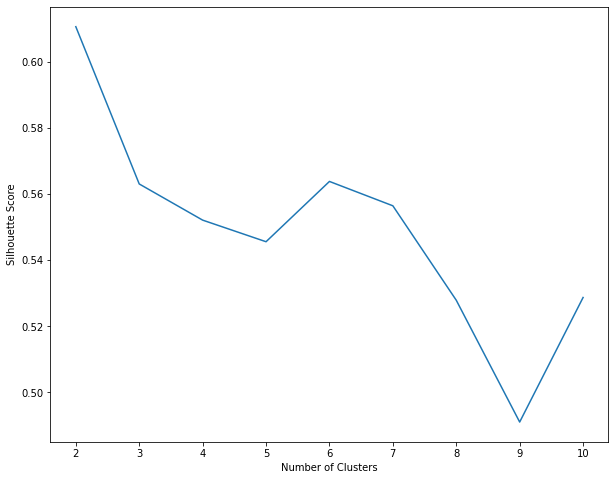

In [125]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
print('绘制轮廓分数与聚类数量的关系')